In [1]:
import warnings
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import assemble
from qiskit import pulse
from qiskit.pulse import pulse_lib
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# Pick your favorite (not busy) Backend 

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-internal',group='dev-qiskit')
backend = provider.get_backend('ibmq_johannesburg')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"
backend_defaults = backend.defaults()

dt = backend_config.dt
print(f"Sampling time: {dt} ns")    # The configuration returns dt in seconds

Sampling time: 3.5555555555555554e-09 ns


In [3]:
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)

# Choosing Qubit & Extract Default Gates
Part of OpenPulse is that you can choose to extract the already made/calibrated waveforms. Below we will extract the X gate and the default measurement gate.  In this notebook we will later show how one can tune up the readout pulse itself

In [4]:
qubit = 0
x_gate = cmd_def.get('u3', [qubit], P0=np.pi, P1=0.0, P2=np.pi)
measure_gate = cmd_def.get('measure', qubits=backend_config.meas_map[qubit])

# Establishing Various channels
Here we are establishing the various channels to be used.  Note: Measure channel refers to channel that send readout pulses whereas acquire channel refers to the actual download of the readout pulse. All acquire pulses must happen at the same time and no pulses can occur after (currently).

In [5]:
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# Set common measurement time
Readout can sometimes be sensitive to phase and timing.  For this reason it's useful to set a common readout time

In [6]:
measure_time = 40

# Comparing |0> and |1> state distributions
Here, using the default pulses from the backend, we will compare the distributions of measurment level 1 values and then construct a readout discriminator (which is equivalent to measurement level 2)

In [7]:
schedule = pulse.Schedule(name='Distribution Comparisons')
schedule += x_gate
schedule +=  measure_gate << measure_time

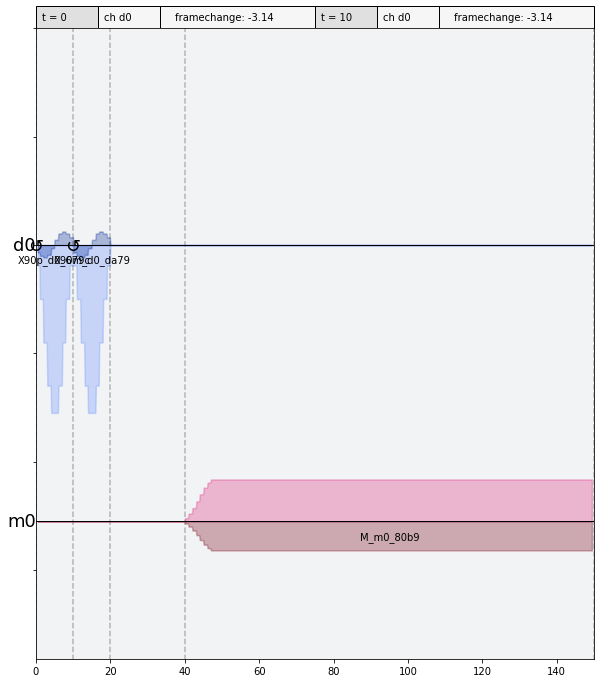

In [10]:
schedule.draw(plot_range=[0,150],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=10.0)

In [9]:
meas_schedule = pulse.Schedule(name='Distribution Comparisons')
meas_schedule += cmd_def.get('measure', qubits=backend_config.meas_map[qubit]) << measure_time

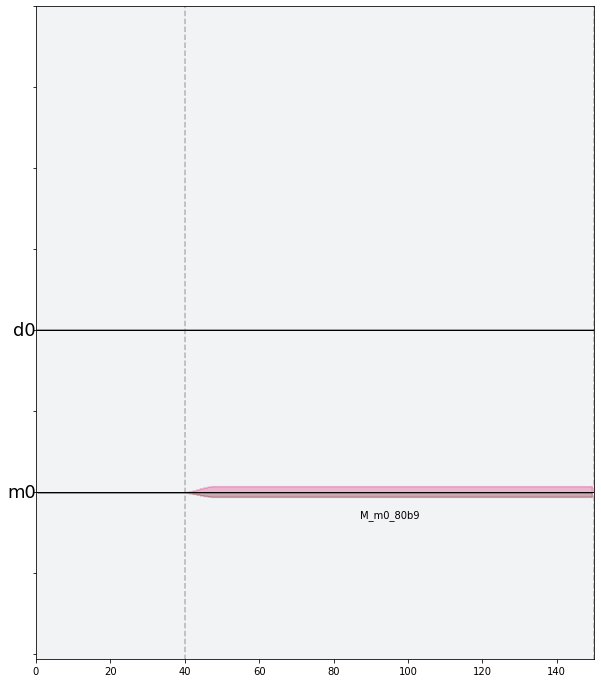

In [10]:
meas_schedule.draw(plot_range=[0,150],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [11]:
num_shots_per_frequency = 8192
readout_cal = assemble([schedule,meas_schedule],
                               backend=backend, 
                               meas_level=1,
                               meas_return='single',
                               shots=num_shots_per_frequency)
job = backend.run(readout_cal)
print (job.job_id())

5e2f6ca31663de0019d01c3a


In [12]:
distribution_compare = backend.retrieve_job('5e2f6ca31663de0019d01c3a')
distribution_compare_result = distribution_compare.result(timeout=3600)

In [13]:
ground = [shot[0] for shot in distribution_compare_result.get_memory(1)]
excited = [shot[0] for shot in distribution_compare_result.get_memory(0)]

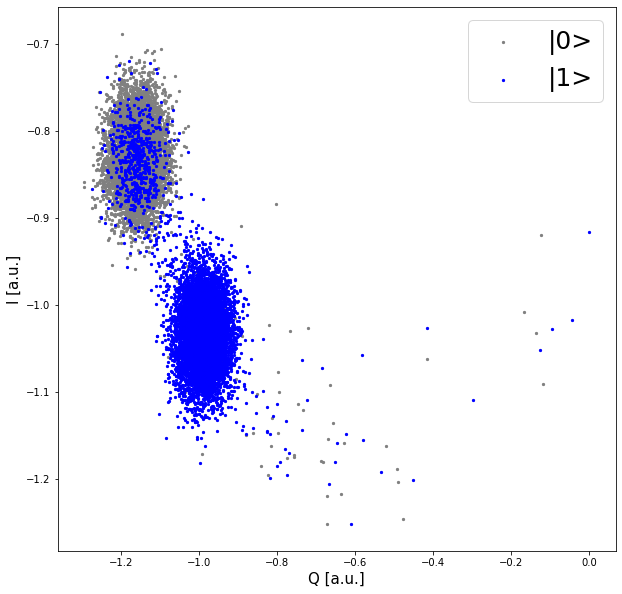

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(np.real(ground)/1e15, np.imag(ground)/1e15,s=5, cmap='viridis', c='grey',alpha=1.0, label='state_0_mean')

plt.scatter(np.real(excited)/1e15, np.imag(excited)/1e15,s=5, cmap='viridis', c='blue',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)

plt.legend(["|0>","|1>"],fontsize=25)
plt.show()

In [15]:
mean_gnd = np.mean(ground) # takes mean of both real and imaginary parts
mean_exc = np.mean(excited)

### Making a discriminator
This is a simple discriminator that assigns based on closest proximity to the means

In [16]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

In [17]:
fidelity_g = []
fidelity_e = []
for i in range(len(excited)):
    fidelity_g.append(classify(ground[i]))
    fidelity_e.append(classify(excited[i]))

# Tuning Up your own readout pulse
Here we will continue to use the default X gate, but will show the affect of adjusting the readout pulse

In [18]:
def get_closest_multiple_of_16(num):
    return (int(num) - (int(num)%16))

In [19]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [20]:
meas_samples_us = 4.0
meas_sigma_us = 1.0     # The width of the gaussian part of the rise and fall
meas_risefall_us = 0.1    # and the truncating parameter: how many samples to dedicate to the risefall

meas_samples = get_closest_multiple_of_16(meas_samples_us * 1e-6/dt)
meas_sigma = get_closest_multiple_of_16(meas_sigma_us * 1e-6/dt)         # The width of the gaussian part of the rise and fall
meas_risefall = get_closest_multiple_of_16(meas_risefall_us * 1e-6/dt)  


meas_amp = 0.2

In [21]:
acq_cmd = pulse.Acquire(duration=meas_samples)

In [22]:
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples,
                                       sigma=meas_sigma,
                                       amp=meas_amp,
                                       risefall=meas_risefall,
                                       name='measurement_pulse')

measure_schedule = meas_pulse(meas_chan)<<measure_time
measure_schedule += acq_cmd([pulse.AcquireChannel(i) for i in backend_config.meas_map[meas_map_idx]],
                            [pulse.MemorySlot(i) for i in backend_config.meas_map[meas_map_idx]])



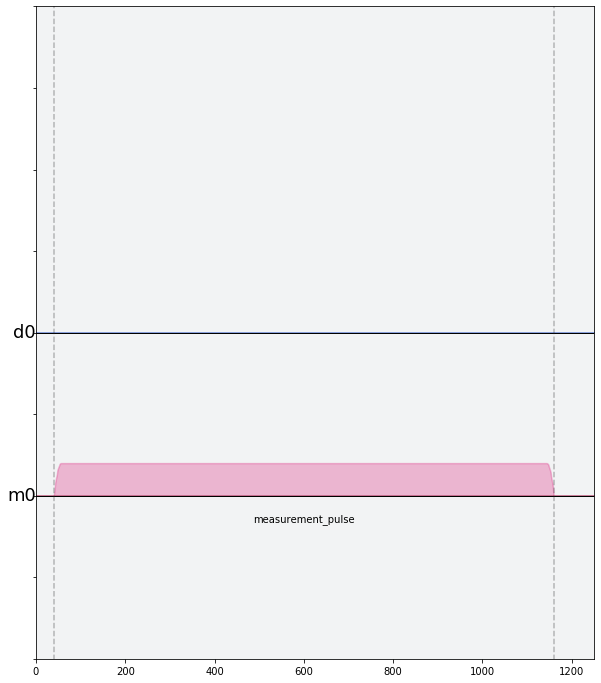

In [23]:
measure_schedule.draw(plot_range=[0,1250],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [24]:
schedule = pulse.Schedule(name='Readout_Discrim')
schedule += x_gate
schedule +=  measure_schedule << measure_time




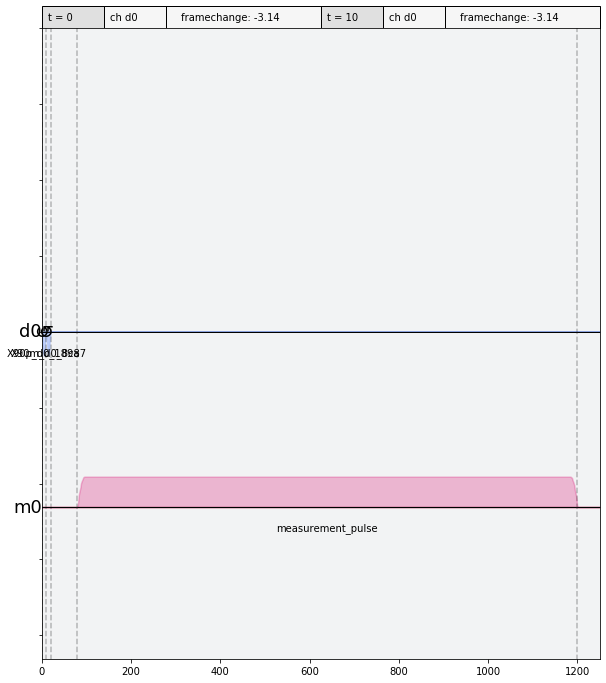

In [25]:
schedule.draw(plot_range=[0,1250],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [26]:
num_shots_per_frequency = 8192
readout_cal = assemble([schedule,measure_schedule],
                               backend=backend, 
                               meas_level=1,
                               meas_return='single',
                               shots=num_shots_per_frequency)
job = backend.run(readout_cal)
print (job.job_id())

5e2f6d496d9b6d001c2cd56b


In [30]:
readout_tune = backend.retrieve_job('5e2f6d496d9b6d001c2cd56b') #amp is 0.2 4us pulse


readout_tune_result = readout_tune.result(timeout=3600)

In [214]:
ground = [shot[0] for shot in readout_tune_result.get_memory(1)]
excited = [shot[0] for shot in readout_tune_result.get_memory(0)]

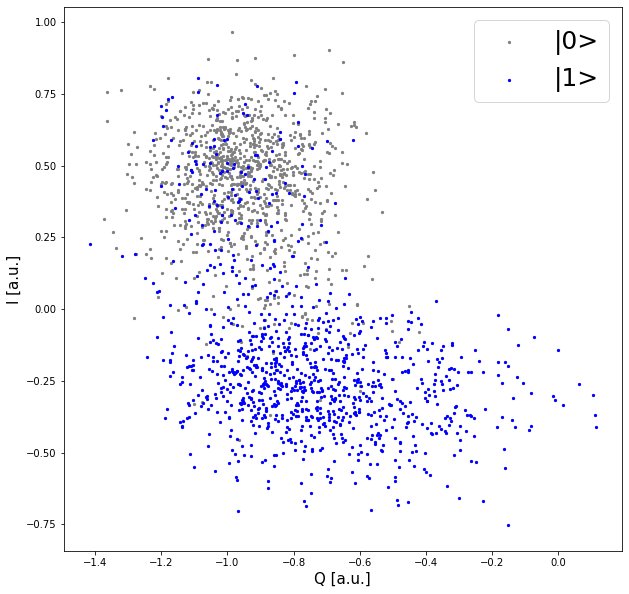

In [215]:
plt.figure(figsize=(10,10))
plt.scatter(np.real(ground)/1e15, np.imag(ground)/1e15,s=5, cmap='viridis', c='grey',alpha=1.0, label='state_0_mean')

plt.scatter(np.real(excited)/1e15, np.imag(excited)/1e15,s=5, cmap='viridis', c='blue',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)

plt.legend(["|0>","|1>"],fontsize=25)
plt.show()

In [216]:
mean_gnd = np.mean(ground) # takes mean of both real and imaginary parts
mean_exc = np.mean(excited)
fidelity_g = []
fidelity_e = []
for i in range(len(excited)):
    fidelity_g.append(classify(ground[i]))
    fidelity_e.append(classify(excited[i]))

In [217]:
print (np.sum(fidelity_g)/len(fidelity_g))
print (np.sum(fidelity_e)/len(fidelity_e))

0.0859375
0.8564453125


# Measuring the $\chi$ resonator shift

In [10]:
GHz = 1.0e9
MHz = 1.0e6

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.meas_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 2 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 0.1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min, 
                            frequency_max, 
                            frequency_step_Hz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 7.082440095 GHz.
The sweep will go from 7.081440095 GHz to 7.083440095 GHz in steps of 0.1 MHz.


In [11]:
qubit = 0
x_gate = cmd_def.get('u3', [qubit], P0=np.pi, P1=0.0, P2=np.pi)
measure_gate = cmd_def.get('measure', qubits=backend_config.meas_map[qubit])

schedule0 = pulse.Schedule(name='Readout Frequency sweep')
schedule0 += measure_gate <<measure_time

schedule1 = pulse.Schedule(name='Readout Frequency sweep')
schedule1 += x_gate
schedule1 += measure_gate <<measure_time

schedule_frequencies = [{meas_chan: freq} for freq in frequencies_GHz]

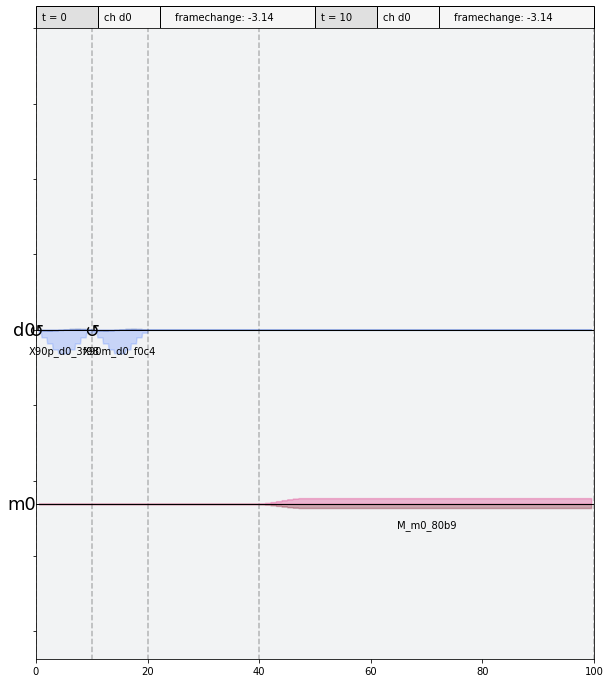

In [12]:
schedule1.draw(plot_range=[0,100],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [13]:
num_shots_per_frequency = 8192
ground_resonator_freq_sweep = assemble(schedule0,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)


job = backend.run(ground_resonator_freq_sweep)
print (job.job_id())

5e2f3e9151c04c0018c7d91a


In [14]:
num_shots_per_frequency = 8192
excited_resonator_freq_sweep = assemble(schedule1,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)


job = backend.run(excited_resonator_freq_sweep)
print (job.job_id())

5e2f3e94c4ffc4001882be47


In [28]:
# chi_test_codes = ["5e2f1fbf3648b10018931256","5e2f1fc56840bc0018a436f6"] #codes for singapore backend
# chi_test_codes = ["5e2f2cd851c04c0018c7d86d","5e2f2cdaf5a50800187c237d"] #codes for johannesburg backend
# chi_test_codes = ["5e2f2d8df5a50800187c2380","5e2f2d9051c04c0018c7d877"] #codes for johannesburg backend
# chi_test_codes = ["5e2f302f6840bc0018a437a0","5e2f30323648b10018931300"] #codes for johannesburg backend
chi_test_codes = ["5e2f3e9151c04c0018c7d91a","5e2f3e94c4ffc4001882be47"] #codes for johannesburg backend
qubit=0
all_vals = []
for i in range(len(chi_test_codes)):
    sweep_values = []
    job = backend.retrieve_job(chi_test_codes[i])
    frequency_sweep_results = job.result(timeout=120)
    for j in range(len(frequency_sweep_results.results)):
        res = frequency_sweep_results.get_memory(j)
        sweep_values.append(res[qubit])
    all_vals.append(sweep_values)
    



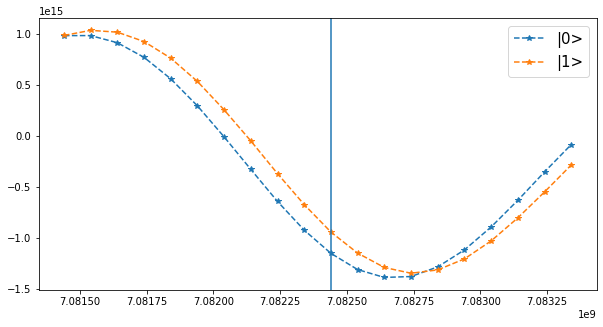

In [30]:
plt.figure(figsize=(10,5))
for i in range(len(chi_test_codes)):
    plt.plot(frequencies_GHz, all_vals[i],"*--")
plt.axvline(center_frequency_Hz)
plt.legend(["|0>","|1>"],fontsize=15)
plt.show()